In [52]:
%matplotlib inline

import os
import datetime
import time
import json

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, KFold

from scipy.sparse import csr_matrix

In [33]:
TfidfVectorizer??

In [5]:
## daily prices

def preprbd(x_db):
    x_db.columns = [x.lower() for x in x_db.columns.values]
    ## x_db.drop(['date_text','month','month day','day','year'],axis=1,inplace=True)
    x_db.drop(['open','high','low','market cap'],axis=1,inplace=True)


bit_price_d = pd.read_excel("bitcoin_data/btc_close_daily.xlsx")
preprbd(bit_price_d)
bit_price_d.rename(columns={'close':'btc_close'},inplace=True)


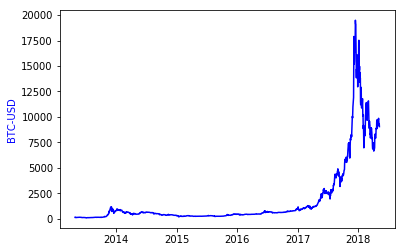

In [6]:
fig, ax1 = plt.subplots()

ax1.plot(bit_price_d['date'],bit_price_d['btc_close'],'b')
ax1.set_ylabel('BTC-USD',color='b')


plt.show()

#### Reading news

In [7]:
re.sub("([0-9]*),([0-9]*)","\\1\\2","ninth in terms of BTC/USD ($1,536,570) trading")

'ninth in terms of BTC/USD ($1536570) trading'

In [796]:
%%time

def clean_text(text):
    text = re.sub("<.*?>.*?</.*?>","",text)
    text = re.sub("&amp;","&",text)
    text = re.sub("\n"," ",text)
    text = re.sub("'","",text)
    text = re.sub("\$([0-9])","USD \\1",text)
    text = re.sub("([0-9])k","\\1 thousands",text)    
    text = re.sub("([0-9])m","\\1 million",text)
    text = re.sub("([0-9])bn","\\1 billion",text)
    text = re.sub("([0-9]*),([0-9]*)","\\1\\2",text)  ## removing thousands separator
    text = re.sub("R&D","RnD",text)

    return text
    

## Loading text
DIR_FILE = "news_coindesk"
news_corpus = []
for i_file in os.listdir(DIR_FILE):
    
    # read file
    tt = open (DIR_FILE + "/"+i_file)
    
    # process headline
    news_headline = tt.readline()
    news_headline = re.sub("\n","",news_headline)
    news_headline = clean_text(news_headline)

    # now time for time
    news_time = tt.readline()
    news_time = datetime.datetime.strptime(news_time[0:10],"%Y-%m-%d")
    
    # news text and brief
    news_text = "".join(tt.readlines())
    try:
        news_brief = re.search("<brief>(.*?)</brief>",news_text).group(1)
    except:
        news_brief = ""
    news_text = clean_text(news_text)
    news_corpus.append([news_time,news_headline,news_text])
    
    
print ("text loaded")

news_corpus = pd.DataFrame(news_corpus)
news_corpus.columns = ['date_orig','headline','text']


## aggregate text and headlines on daily level
def compute_metrics(x):
    result = {'headline': " ".join(x['headline']), 'text': " ".join(x['text']),'count_news':len(x)}
    return pd.Series(result, name='metrics')

news_corpus = news_corpus.groupby('date_orig').apply(compute_metrics)



news_corpus.sort_index(inplace=True)
news_corpus.reset_index(inplace=True)


## MAKE DATE SHIFT
## current news predict next date price
# cd_news['date'] = [x + datetime.timedelta(days=0) for x in cd_news['date']]

print ("metrics computed")

news_corpus.head()

text loaded
metrics computed
Wall time: 7.27 s


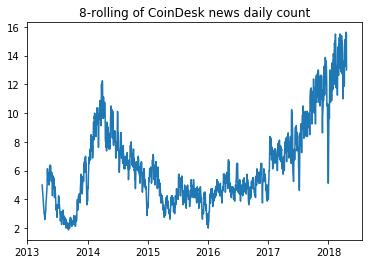

In [797]:
## Plot news count

fig, axs = plt.subplots()

aa = news_corpus.rolling(8,min_periods=1)['count_news'].mean()
axs.plot(news_corpus['date_orig'],aa)
axs.title.set_text("8-rolling of CoinDesk news daily count")
plt.show()


#### Explanation model

In [817]:
%%time

##  Get daily spot price
##
all_data = bit_price_d[['date','btc_close']].copy(deep=True)
all_data.sort_values('date',ascending=True,inplace=True)
all_data.reset_index(inplace=True)
all_data.drop('index',axis=1,inplace=True)


## make returns
price = all_data['btc_close']
price_l1 = all_data['btc_close'].shift(1)
all_data['btc_return'] = np.log(price) - np.log(price_l1)
all_data['btc_dir'] = all_data['btc_return']>0
all_data.dropna(inplace=True)


##  merge with news
row_filter = (all_data['date']>=np.min(news_corpus['date_orig'])) & (all_data['date']<=np.max(news_corpus['date_orig']))
all_data = all_data.loc[row_filter,:].copy(deep=True)


news_corpus['date'] = [x + datetime.timedelta(days=0) for x in news_corpus['date_orig']]

all_data = all_data.merge(news_corpus[['date','count_news','headline','text']],how='left',on='date')
all_data.fillna('',inplace=True)

filt = [x=='' for x in all_data['count_news']]
all_data.loc[filt,'count_news']=0


class LemmaTokenizer():
     def __init__(self):
        self.stm = SnowballStemmer('english')
        self.tkn = RegexpTokenizer(r'\w+')
     def __call__(self, doc):
         return [self.stm.stem(t) for t in self.tkn.tokenize(doc)]
         ##return [self.stm.stem(t) for t in word_tokenize(doc)]

## make headlines
##
tfidf = TfidfVectorizer(ngram_range=(1,2),min_df=5, tokenizer=LemmaTokenizer(),
                       stop_words='english')
tfidif_headline = tfidf.fit_transform(all_data['headline'])
tfidf_col_names = tfidf.get_feature_names() 
print (tfidif_headline.shape)
print ("headline processed")

tfidf = TfidfVectorizer(ngram_range=(1,2),min_df=25, tokenizer=LemmaTokenizer(),
                       stop_words='english')
tfidif_text = tfidf.fit_transform(all_data['text'])
tfidf_col_names += tfidf.get_feature_names()
print (tfidif_text.shape)
print ("text processed")


## add column with news counts
tfidif_vectors = hstack([csr_matrix(all_data[['count_news']].astype(float)),tfidif_headline,tfidif_text],format='csr')
tfidf_col_names = ['#var_count_news'] + tfidf_col_names

##tfidif_vectors = hstack([tfidif_headline,tfidif_text],format='csr')
## tfidif_vectors = tfidif_headline


print (tfidif_vectors.shape)
## tfidif_vectors
all_data

(1819, 3810)
headline processed
(1819, 17379)
text processed
(1819, 21190)
Wall time: 1min 26s


In [819]:
## split into test and train
##

train_size =0.95
train_ind = int(all_data.shape[0] * train_size)
print (all_data.loc[train_ind,'date'])


matr = tfidif_vectors

dates_train =all_data.loc[:train_ind,'date']
X_train = matr[:train_ind+1,]
y_train = all_data.loc[:train_ind,'btc_return']

dates_test = all_data.loc[train_ind+1:,'date']
X_test = matr[train_ind+1:,]
y_test =  all_data.loc[train_ind+1:,'btc_return']

2018-01-21 00:00:00


Text(0.5,1,'BTC return log(S)-log(S_1)')

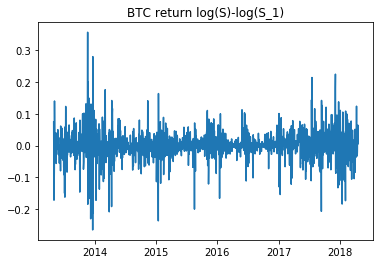

In [820]:
fig, ax = plt.subplots()
ax.plot(all_data['date'],all_data['btc_return'])
ax.set_title("BTC return log(S)-log(S_1)")

#### Ridge Model

In [821]:
def model_predict (mm,titles=["",""]):
    assert len(titles)==2
    
    print ("Fitting the model")
    mm.fit(X_train,y_train)
    
    print (mm)
    y_pred = mm.predict(X_test)

    print ("RMSE test: ", mean_squared_error(y_pred,y_test))
    print ("R2 test: ",r2_score(y_pred,y_test))


    y_pred = mm.predict(X_train)

    print ("RMSE train: ",mean_squared_error(y_pred,y_train))
    print ("R2 train: ",r2_score(y_pred,y_train))

    ## Plot train data
    fig, (axs,axs2) = plt.subplots(1,2, figsize=(15,5))
    axs.plot(dates_train,y_train,'b')
    axs.plot(dates_train,y_pred,'r')
    axs.set_title(titles[0])
    ## Plot test data
    y_pred = mm.predict(X_test)
    
    ##fig2, (axs2) = plt.subplots()
    axs2.plot(dates_test,y_test,'b')
    axs2.plot(dates_test,y_pred,'r')
    axs2.set_title(titles[1])

    fig.autofmt_xdate()
    plt.show()

In [822]:

def model_kfold_predict (mm, folds_num = 4):
    rmse_scores = []
    r2_scores = []

    kf = KFold (n_splits=folds_num,shuffle=False)
    for train_index, test_index in kf.split(X_train):
        X_fold_train, X__fold_test = X_train[train_index], X_train[test_index]
        y_fold_train, y__fold_test = y_train[train_index], y_train[test_index]

        mm.fit(X_fold_train, y_fold_train)
        y_pred = mm.predict(X__fold_test)

        a1 = mean_squared_error(y_pred,y__fold_test)
        a2 = r2_score(y_pred,y__fold_test)

        rmse_scores.append(a1)
        r2_scores.append(a2)

    print ("KFold RMSE: ",["{0:.4f}".format(x) for x in rmse_scores], np.mean(rmse_scores))
    print ("KFold RMSE: ",["{0:.2f}".format(x) for x in r2_scores], np.mean(r2_scores))

KFold RMSE:  ['0.0020', '0.0063', '0.0013', '0.0021', '0.0010', '0.0011', '0.0009', '0.0007', '0.0018', '0.0036'] 0.00206456771141
KFold RMSE:  ['-20.76', '-67.95', '-9.46', '-17.49', '-7.62', '-9.14', '-6.98', '-4.99', '-8.28', '-23.89'] -17.6556158304
Fitting the model
Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
RMSE test:  0.00293660653311
R2 test:  -19.333239385
RMSE train:  0.000849871959991
R2 train:  -1.41308546402


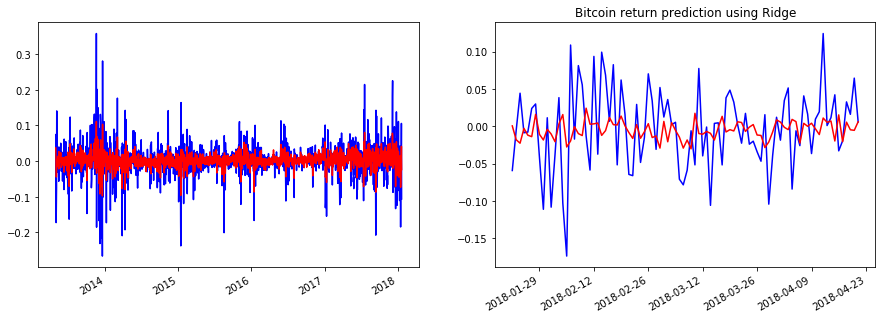

In [823]:
rdg = Ridge(alpha=1, fit_intercept=True, normalize=False)

model_kfold_predict(rdg,folds_num=10)
model_predict(rdg,["","Bitcoin return prediction using Ridge"])    

In [824]:
ind = np.argsort(np.abs(rdg.coef_))
ind = ind[::-1]

for i_ind in ind[0:20]:
    feat = tfidf_col_names[i_ind]
    print (feat, rdg.coef_[i_ind])


drop -0.0547605243076
price drop -0.0445815059531
drop usd -0.0433770776923
fall -0.0407284926075
high 0.0390665698758
miner 0.0343074445839
offici -0.0325386999389
pass 0.0308081809046
patent 0.0307477307281
realli -0.0304395338952
core develop -0.0295112827074
price declin -0.0288636321194
time 0.0286082088463
set 0.0277585950099
exchang btc 0.0272788854062
need new -0.0262289045775
largest 0.0261270495365
fight -0.0257243811228
declin -0.0255004413537
slump -0.0253366690037


#### Extra Trees

In [827]:
%%time
kf = KFold (n_splits=4)

for i_tree in np.arange(10,20,10):
    etr = ExtraTreesRegressor(n_estimators=i_tree, criterion='mse', 
                               max_depth=None, min_samples_split=2, 
                               min_samples_leaf=1, n_jobs = -1, random_state=14)

    ##scores = cross_val_score(etr, X_train,y_train,cv=kf,scoring ='neg_mean_squared_error')
    print (i_tree, np.mean(scores), scores)

10 -0.00300305756549 [-0.00378544 -0.0028153  -0.00176574 -0.00364574]
Wall time: 500 µs


In [829]:
%%time
etr  = ExtraTreesRegressor(n_estimators=50, criterion='mse', 
                           max_depth=None, min_samples_split=2, 
                           min_samples_leaf=5, n_jobs = -1, 
                           random_state=14, bootstrap = True, 
                           oob_score  = False)
etr.fit(X_train,y_train)

Wall time: 21.1 s


Fitting the model
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=5, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
          oob_score=False, random_state=14, verbose=0, warm_start=False)
RMSE test:  0.00240336524584
R2 test:  -9.84401651217
RMSE train:  0.000724452513344
R2 train:  -0.635021363585


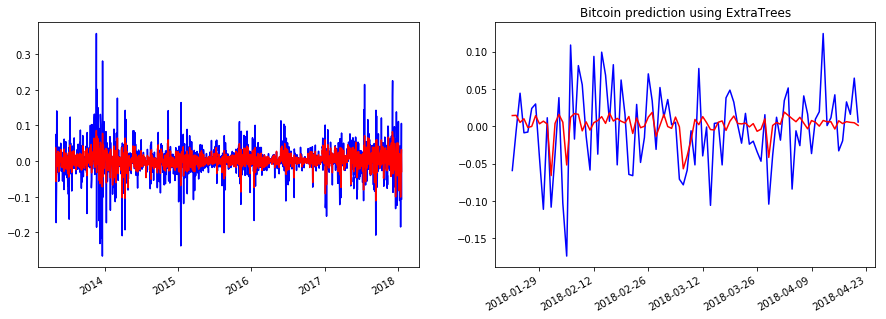

In [830]:
## model_kfold_predict(etr)
model_predict(etr,titles=["","Bitcoin prediction using ExtraTrees"])

In [831]:
imp = etr.feature_importances_
ind = np.argsort(imp)
ind = ind[::-1]

for i_ind in ind[0:20]:
    feat = tfidf_col_names[i_ind]
    print (feat, imp[i_ind])


price drop 0.0464471660268
hit low 0.0143189901787
drop usd 0.00960973094704
senat hear 0.00905583636807
drop 0.00653906530518
slump 0.00587791113058
ani offici 0.00518438834853
time high 0.00489557087221
exchang btc 0.00435098105959
bitcoin price 0.00380791337459
bpi price 0.00376402388521
price surg 0.00351450273213
miami 0.00346994631869
high 0.00336440652763
gox bitstamp 0.00331742820293
bpi 0.00328241630062
app develop 0.00290470326808
bitcoin 0.00289943420425
pariti 0.002776331862
hour period 0.00260723715172


Ridge MSE 0.00305
ExtraTrees MSE 0.00239


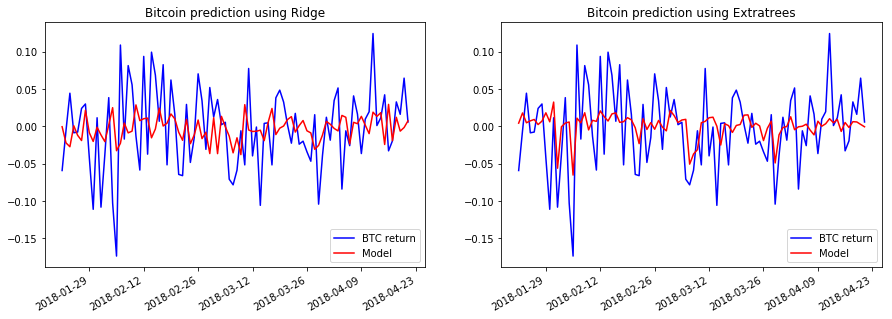

In [729]:
## Plot  data
fig, (axs,axs2) = plt.subplots(1,2, figsize=(15,5))

##fig2, (axs2) = plt.subplots()
y_pred = rdg.predict(X_test)
print ("Ridge MSE {0:.5f}".format(mean_squared_error(y_pred,y_test)))
axs.plot(dates_test,y_test,'b')
axs.plot(dates_test,y_pred,'r')
axs.set_title("Bitcoin prediction using Ridge")

axs.legend( ['BTC return', 'Model'])

y_pred = etr.predict(X_test)
print ("ExtraTrees MSE {0:.5f}".format(mean_squared_error(y_pred,y_test)))
axs2.plot(dates_test,y_test,'b')
axs2.plot(dates_test,y_pred,'r')
axs2.set_title("Bitcoin prediction using Extratrees")
axs2.legend( ['BTC return', 'Model'])
fig.autofmt_xdate()
plt.show()